In [1]:
!pip -q install pandas matplotlib requests

import requests
import pandas as pd
import matplotlib.pyplot as plt


In [9]:
BASE_URL = "https://api.openaq.org/v2/measurements"

def fetch_openaq_by_coords(lat=23.2599, lon=77.4126, radius=25000, parameter="pm25", limit=1000, pages=5):
    all_rows = []
    for page in range(1, pages+1):
        params = {
            "coordinates": f"{lat},{lon}",
            "radius": radius,
            "parameter": parameter,
            "limit": limit,
            "page": page,
            "sort": "desc",
            "order_by": "datetime"
        }

        r = requests.get(BASE_URL, params=params)
        data = r.json()

        if "results" not in data or len(data["results"]) == 0:
            break

        all_rows.extend(data["results"])

    return pd.json_normalize(all_rows)

pm25_df = fetch_openaq_by_coords(parameter="pm25", pages=10)
pm10_df = fetch_openaq_by_coords(parameter="pm10", pages=10)

print("PM2.5 rows:", len(pm25_df))
print("PM10 rows:", len(pm10_df))

pm25_df.head()


PM2.5 rows: 0
PM10 rows: 0


""


In [10]:
def clean_data(df):
    df = df.copy()

    # Find the correct datetime column
    if "date.utc" in df.columns:
        df["datetime"] = pd.to_datetime(df["date.utc"])
    elif "date.local" in df.columns:
        df["datetime"] = pd.to_datetime(df["date.local"])
    elif "date" in df.columns:
        df["datetime"] = pd.to_datetime(df["date"])
    else:
        raise ValueError("No date column found in the dataset")

    df["date_only"] = df["datetime"].dt.date

    # Some OpenAQ responses use 'unit', some don't
    keep_cols = []
    for col in ["date_only", "datetime", "value", "unit", "location"]:
        if col in df.columns:
            keep_cols.append(col)

    df = df[keep_cols]
    df = df.dropna(subset=["value"])

    return df



In [11]:
print(pm25_df.head())
print(pm10_df.head())
print("PM2.5 count:", len(pm25_df))
print("PM10 count:", len(pm10_df))


Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
PM2.5 count: 0
PM10 count: 0


In [12]:
import zipfile
import pandas as pd

zip_path = "/mnt/data/archive.zip"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("/mnt/data/aqi_data")

df = pd.read_csv("/mnt/data/aqi_data/AQI.csv")
print(df.shape)
df.head()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/archive.zip'

In [13]:
import zipfile
import pandas as pd
import os

zip_path = "/content/archive.zip"

# Extract zip
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("/content/aqi_data")

print("Extracted files:", os.listdir("/content/aqi_data"))

# Load CSV
df = pd.read_csv("/content/aqi_data/AQI.csv")
print("Dataset shape:", df.shape)

df.head()


Extracted files: ['AQI.csv']
Dataset shape: (3077, 11)


,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,pollutant_avg
0,India,Andhra_Pradesh,Vijayawada,"Rajiv Nagar, Vijayawada - APPCB",19-05-2025 10:00:00,16.554731,80.649110,SO2,20.0,23.0,21.0
1,India,Andhra_Pradesh,Vijayawada,"Rajiv Nagar, Vijayawada - APPCB",19-05-2025 10:00:00,16.554731,80.649110,OZONE,17.0,35.0,22.0
2,India,Andhra_Pradesh,Visakhapatnam,"GVM Corporation, Visakhapatnam - APPCB",19-05-2025 10:00:00,17.720000,83.300000,PM10,23.0,66.0,36.0
3,India,Arunachal_Pradesh,Naharlagun,"Naharlagun, Naharlagun - APSPCB",19-05-2025 10:00:00,27.103358,93.679645,NO2,4.0,5.0,5.0
4,India,Arunachal_Pradesh,Naharlagun,"Naharlagun, Naharlagun - APSPCB",19-05-2025 10:00:00,27.103358,93.679645,CO,10.0,19.0,12.0


In [14]:
bhopal = df[df["city"].str.lower() == "bhopal"].copy()
print("Bhopal rows:", bhopal.shape)

bhopal.head()


Bhopal rows: (21, 11)


,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,pollutant_avg
214,India,Madhya Pradesh,Bhopal,"Idgah Hills, Bhopal - MPPCB",19-05-2025 10:00:00,23.264759,77.381568,NO2,18.0,61.0,29.0
215,India,Madhya Pradesh,Bhopal,"Idgah Hills, Bhopal - MPPCB",19-05-2025 10:00:00,23.264759,77.381568,NH3,5.0,8.0,6.0
216,India,Madhya Pradesh,Bhopal,"Idgah Hills, Bhopal - MPPCB",19-05-2025 10:00:00,23.264759,77.381568,CO,7.0,56.0,10.0
217,India,Madhya Pradesh,Bhopal,"Paryavaran Parisar, Bhopal - MPPCB",19-05-2025 10:00:00,23.210494,77.425409,PM10,34.0,96.0,57.0
218,India,Madhya Pradesh,Bhopal,"Paryavaran Parisar, Bhopal - MPPCB",19-05-2025 10:00:00,23.210494,77.425409,OZONE,28.0,61.0,41.0


In [15]:
bhopal_pm = bhopal[bhopal["pollutant_id"].isin(["PM2.5", "PM10"])].copy()

print(bhopal_pm["pollutant_id"].value_counts())
bhopal_pm.head()


pollutant_id
PM10     3
PM2.5    3
Name: count, dtype: int64


,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,pollutant_avg
217,India,Madhya Pradesh,Bhopal,"Paryavaran Parisar, Bhopal - MPPCB",19-05-2025 10:00:00,23.210494,77.425409,PM10,34.0,96.0,57.0
840,India,Madhya Pradesh,Bhopal,"T T Nagar, Bhopal - MPPCB",19-05-2025 10:00:00,23.233584,77.400574,PM10,NaN,NaN,NaN
2037,India,Madhya Pradesh,Bhopal,"T T Nagar, Bhopal - MPPCB",19-05-2025 10:00:00,23.233584,77.400574,PM2.5,25.0,60.0,38.0
2057,India,Madhya Pradesh,Bhopal,"Idgah Hills, Bhopal - MPPCB",19-05-2025 10:00:00,23.264759,77.381568,PM2.5,35.0,83.0,55.0
2651,India,Madhya Pradesh,Bhopal,"Idgah Hills, Bhopal - MPPCB",19-05-2025 10:00:00,23.264759,77.381568,PM10,60.0,116.0,89.0


In [16]:
pivot = bhopal_pm.pivot_table(
    index=["station", "latitude", "longitude", "last_update"],
    columns="pollutant_id",
    values="pollutant_avg",
    aggfunc="mean"
).reset_index()

pivot


pollutant_id,station,latitude,longitude,last_update,PM10,PM2.5
0,"Idgah Hills, Bhopal - MPPCB",23.264759,77.381568,19-05-2025 10:00:00,89.0,55.0
1,"Paryavaran Parisar, Bhopal - MPPCB",23.210494,77.425409,19-05-2025 10:00:00,57.0,47.0
2,"T T Nagar, Bhopal - MPPCB",23.233584,77.400574,19-05-2025 10:00:00,NaN,38.0


In [17]:
pivot["PM2.5"] = pivot["PM2.5"].fillna(0)
pivot["PM10"] = pivot["PM10"].fillna(0)

pivot


pollutant_id,station,latitude,longitude,last_update,PM10,PM2.5
0,"Idgah Hills, Bhopal - MPPCB",23.264759,77.381568,19-05-2025 10:00:00,89.0,55.0
1,"Paryavaran Parisar, Bhopal - MPPCB",23.210494,77.425409,19-05-2025 10:00:00,57.0,47.0
2,"T T Nagar, Bhopal - MPPCB",23.233584,77.400574,19-05-2025 10:00:00,0.0,38.0


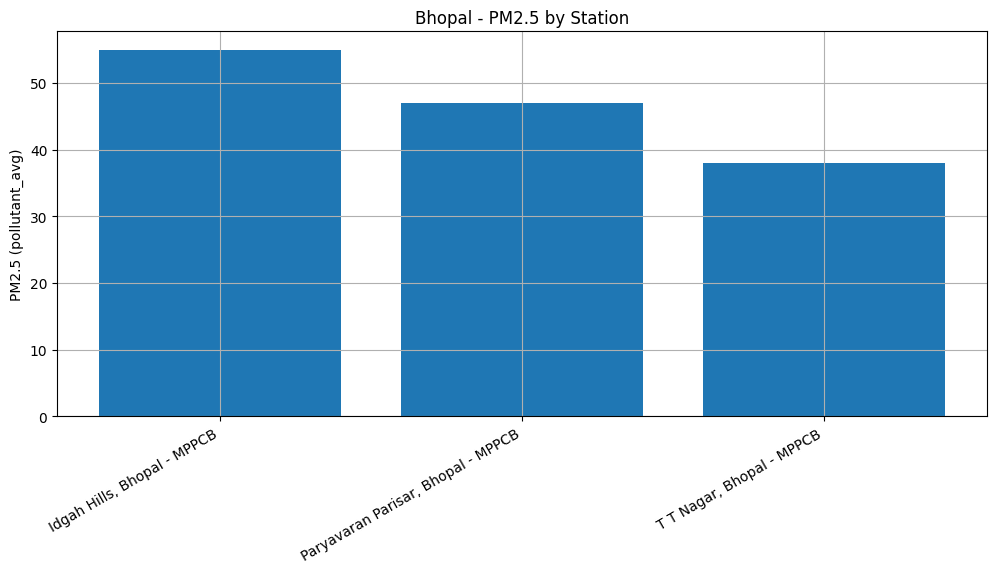

In [18]:
import matplotlib.pyplot as plt

pm25_sorted = pivot.sort_values("PM2.5", ascending=False)

plt.figure(figsize=(12,5))
plt.bar(pm25_sorted["station"], pm25_sorted["PM2.5"])
plt.xticks(rotation=30, ha="right")
plt.title("Bhopal - PM2.5 by Station")
plt.ylabel("PM2.5 (pollutant_avg)")
plt.grid(True)
plt.show()


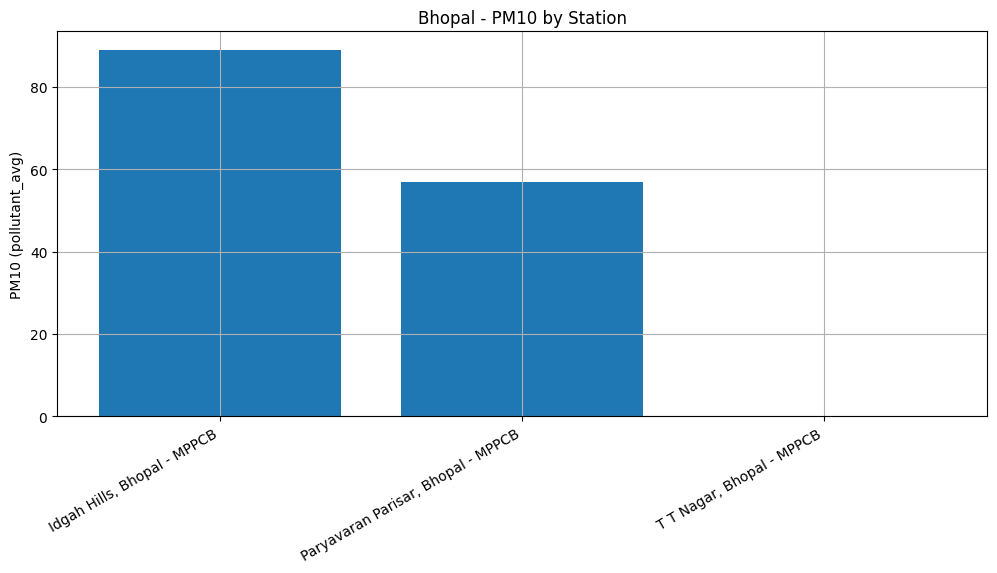

In [19]:
pm10_sorted = pivot.sort_values("PM10", ascending=False)

plt.figure(figsize=(12,5))
plt.bar(pm10_sorted["station"], pm10_sorted["PM10"])
plt.xticks(rotation=30, ha="right")
plt.title("Bhopal - PM10 by Station")
plt.ylabel("PM10 (pollutant_avg)")
plt.grid(True)
plt.show()


In [20]:
worst_pm25 = pivot.sort_values("PM2.5", ascending=False).head(1)
worst_pm10 = pivot.sort_values("PM10", ascending=False).head(1)

print("Worst station for PM2.5:")
display(worst_pm25)

print("Worst station for PM10:")
display(worst_pm10)


Worst station for PM2.5:


pollutant_id,station,latitude,longitude,last_update,PM10,PM2.5
0,"Idgah Hills, Bhopal - MPPCB",23.264759,77.381568,19-05-2025 10:00:00,89.0,55.0


Worst station for PM10:


pollutant_id,station,latitude,longitude,last_update,PM10,PM2.5
0,"Idgah Hills, Bhopal - MPPCB",23.264759,77.381568,19-05-2025 10:00:00,89.0,55.0


In [21]:
pivot.to_csv("bhopal_stationwise_pm25_pm10.csv", index=False)
print("Saved: bhopal_stationwise_pm25_pm10.csv")


Saved: bhopal_stationwise_pm25_pm10.csv


In [22]:
pivot = bhopal_pm.pivot_table(
    index=["station", "latitude", "longitude", "last_update"],
    columns="pollutant_id",
    values="pollutant_avg",
    aggfunc="mean"
).reset_index()

pivot


pollutant_id,station,latitude,longitude,last_update,PM10,PM2.5
0,"Idgah Hills, Bhopal - MPPCB",23.264759,77.381568,19-05-2025 10:00:00,89.0,55.0
1,"Paryavaran Parisar, Bhopal - MPPCB",23.210494,77.425409,19-05-2025 10:00:00,57.0,47.0
2,"T T Nagar, Bhopal - MPPCB",23.233584,77.400574,19-05-2025 10:00:00,NaN,38.0


In [23]:
pivot_plot = pivot.copy()
pivot_plot["PM10"] = pivot_plot["PM10"].fillna(0)
pivot_plot["PM2.5"] = pivot_plot["PM2.5"].fillna(0)


**Insights**

Idgah Hills shows the highest PM2.5 and PM10 levels among Bhopal monitoring stations in the dataset.

PM10 is significantly higher than PM2.5, suggesting a strong contribution from coarse dust particles (road dust, construction, resuspension).

Missing PM10 values for some stations indicates incomplete pollutant coverage at certain monitoring locations.

In [24]:
def pm25_category(x):
    if pd.isna(x): return "No data"
    if x <= 30: return "Good"
    if x <= 60: return "Satisfactory"
    if x <= 90: return "Moderate"
    if x <= 120: return "Poor"
    if x <= 250: return "Very Poor"
    return "Severe"

def pm10_category(x):
    if pd.isna(x): return "No data"
    if x <= 50: return "Good"
    if x <= 100: return "Satisfactory"
    if x <= 250: return "Moderate"
    if x <= 350: return "Poor"
    if x <= 430: return "Very Poor"
    return "Severe"

pivot["PM2.5_category"] = pivot["PM2.5"].apply(pm25_category)
pivot["PM10_category"] = pivot["PM10"].apply(pm10_category)

pivot


pollutant_id,station,latitude,longitude,last_update,PM10,PM2.5,PM2.5_category,PM10_category
0,"Idgah Hills, Bhopal - MPPCB",23.264759,77.381568,19-05-2025 10:00:00,89.0,55.0,Satisfactory,Satisfactory
1,"Paryavaran Parisar, Bhopal - MPPCB",23.210494,77.425409,19-05-2025 10:00:00,57.0,47.0,Satisfactory,Satisfactory
2,"T T Nagar, Bhopal - MPPCB",23.233584,77.400574,19-05-2025 10:00:00,NaN,38.0,Satisfactory,No data


In [25]:
summary = pivot[["station", "PM2.5", "PM2.5_category", "PM10", "PM10_category"]].copy()
summary


pollutant_id,station,PM2.5,PM2.5_category,PM10,PM10_category
0,"Idgah Hills, Bhopal - MPPCB",55.0,Satisfactory,89.0,Satisfactory
1,"Paryavaran Parisar, Bhopal - MPPCB",47.0,Satisfactory,57.0,Satisfactory
2,"T T Nagar, Bhopal - MPPCB",38.0,Satisfactory,NaN,No data



# Bhopal Air Quality Analysis (PM2.5 & PM10)

## Overview
This project analyzes air pollution levels in Bhopal using real-time monitoring station data from a Kaggle dataset (AQI India 2023–2025). The focus is on particulate pollutants PM2.5 and PM10.

## Dataset
Source: Kaggle - Real-Time Air Quality Index (AQI) India 2023–2025  
The dataset contains pollutant averages reported by monitoring stations across India.

## Objective
- Extract Bhopal air quality readings
- Compare PM2.5 and PM10 across stations
- Identify the worst station for particulate pollution
- Categorize pollution levels into standard air quality categories

## Key Findings
- **Idgah Hills, Bhopal (MPPCB)** shows the highest particulate pollution in the dataset.
- PM10 levels are higher than PM2.5, suggesting a strong contribution from dust particles.
- Some stations have missing pollutant readings (example: PM10 missing for TT Nagar).

## Outputs
- Clean station-wise dataset exported as CSV
- Visualizations for PM2.5 and PM10 station comparison

## Tools Used
- Python
- Pandas
- Matplotlib
- Google Colab


In [27]:
summary = pivot[["station", "PM2.5", "PM10", "last_update"]].copy()
summary = summary.sort_values("PM2.5", ascending=False)

summary


pollutant_id,station,PM2.5,PM10,last_update
0,"Idgah Hills, Bhopal - MPPCB",55.0,89.0,19-05-2025 10:00:00
1,"Paryavaran Parisar, Bhopal - MPPCB",47.0,57.0,19-05-2025 10:00:00
2,"T T Nagar, Bhopal - MPPCB",38.0,NaN,19-05-2025 10:00:00


In [28]:
import pandas as pd

def pm25_category(x):
    if pd.isna(x): return "No data"
    if x <= 30: return "Good"
    if x <= 60: return "Satisfactory"
    if x <= 90: return "Moderate"
    if x <= 120: return "Poor"
    if x <= 250: return "Very Poor"
    return "Severe"

def pm10_category(x):
    if pd.isna(x): return "No data"
    if x <= 50: return "Good"
    if x <= 100: return "Satisfactory"
    if x <= 250: return "Moderate"
    if x <= 350: return "Poor"
    if x <= 430: return "Very Poor"
    return "Severe"

pivot["PM2.5_category"] = pivot["PM2.5"].apply(pm25_category)
pivot["PM10_category"] = pivot["PM10"].apply(pm10_category)

pivot[["station", "PM2.5", "PM2.5_category", "PM10", "PM10_category"]]


pollutant_id,station,PM2.5,PM2.5_category,PM10,PM10_category
0,"Idgah Hills, Bhopal - MPPCB",55.0,Satisfactory,89.0,Satisfactory
1,"Paryavaran Parisar, Bhopal - MPPCB",47.0,Satisfactory,57.0,Satisfactory
2,"T T Nagar, Bhopal - MPPCB",38.0,Satisfactory,NaN,No data


**Conclusion**

Among the monitoring stations available in this dataset, Idgah Hills (MPPCB) recorded the highest PM2.5 and PM10 levels in Bhopal.

PM10 values are higher than PM2.5, which may indicate significant contribution from road dust, construction dust, and resuspended particles.

Some stations have missing pollutant coverage, showing that real-world air quality datasets may contain incomplete observations.

In [29]:
!pip -q install folium


In [30]:
import folium

# Center map around Bhopal
center_lat = pivot["latitude"].mean()
center_lon = pivot["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for _, row in pivot.iterrows():
    station = row["station"]
    pm25 = row.get("PM2.5", None)
    pm10 = row.get("PM10", None)

    popup_text = f"""
    <b>{station}</b><br>
    PM2.5: {pm25}<br>
    PM10: {pm10}<br>
    Last Update: {row['last_update']}
    """

    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=station
    ).add_to(m)

m


In [31]:
m.save("bhopal_air_quality_map.html")
print("Saved: bhopal_air_quality_map.html")


Saved: bhopal_air_quality_map.html


In [33]:
import os
os.makedirs("maps", exist_ok=True)


In [34]:
m.save("maps/bhopal_air_quality_map.html")
print("Saved: maps/bhopal_air_quality_map.html")


Saved: maps/bhopal_air_quality_map.html


## Map Visualization
An interactive map was created using station latitude and longitude values to visualize monitoring station locations in Bhopal.
The map is saved as:
- `maps/bhopal_air_quality_map.html`
